1. Из всего текста отобрать комбинации смежных слов (стоящие рядом в одном предложении), содержащие слово соответствующее Вашему варианту (файл text_sent_1, word1 training). Если слово в варианте указано как word1, то оно должно быть только на первой позиции. На второй позиции может быть любое слово.

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import t
from scipy.stats import chi2

In [2]:
file_path = 'text_sent_1.txt'
target_word = 'training'

total_bigrams = 0
target_word_count = 0

In [3]:
data = {'bigramma': [], 'frequency': []}

In [4]:
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()
        total_bigrams += len(words) - 1

        for i in range(1, len(words)):
            if words[i - 1] == target_word:
                target_word_count += 1
                bigram = f"{target_word} {words[i]}"
                if bigram in data['bigramma']:
                    index = data['bigramma'].index(bigram)
                    data['frequency'][index] += 1
                else:
                    data['bigramma'].append(bigram)
                    data['frequency'].append(1)

In [5]:
target_word_count

481

In [6]:
total_bigrams

176550

In [7]:
tab = pd.DataFrame(data)

In [8]:
tab.to_csv('bi_tab.csv', sep=';', index=True, encoding='utf-8')

2. Проранжировать биграммы по частоте встречаемости. Сделать предварительные выводы о возможных коллокациях.

In [9]:
tab = tab.sort_values(by = 'frequency', ascending = False)

In [10]:
tab.to_csv('bi_tab_sorted.csv', sep=';', index=True, encoding='utf-8')

Collocations или коллокации — это грамматически и лексически правильные словосочетания. Проранжировав наши словосочетания по частоте встречаемости мы можем заметить, что самые часто встречающиеся сочетания вполне могут являться коллокациями, т.к. смысл в них имеется. Также мы можем предположить, что такие биграммы, например, как training of, training an, training from и training if не являются коллокациями, так как между ними не смысловая связь, а только грамматическая. Однако судить об этом по одной только частоте встречаемости может быть опрометчиво.

3. Проранжировать биграммы, отобранные в п. 2, в соответствие с критериями: Стьюдента проверки равенства вероятностей и хи-квадрата Пирсона

Извлечем из полученных биграмм все слова, стоящие на второй позиции

In [11]:
word2_all = []
for bi in tab['bigramma']:
    word2_all.extend(bi.split()[1:])

In [12]:
t_crit = t.ppf(1 - 0.001/2, total_bigrams - 1)
print("Критическое значение для t-test при alfa = 0.001: ", t_crit)

Критическое значение для t-test при alfa = 0.001:  3.2905818429832756


In [13]:
df = 1  # Степени свободы для 2x2 таблицы
chi2_crit = chi2.ppf(1 - 0.001, df)
print("Критическое значение для chi2 при alfa = 0.001: ", chi2_crit)

Критическое значение для chi2 при alfa = 0.001:  10.827566170662733


In [14]:
chi2_test = []
t_stat_list = []
hypothesis_list = []
chi2_hypothesis_list = []

for j in range(len(word2_all)):
    with open(file_path, 'r', encoding='utf-8') as file:
        # file.seek(0)
        O = np.zeros((2, 2))

        for line in file:
            text = line.split()
            for i in range(len(text)):
                if text[i - 1] != target_word and text[i] == word2_all[j]:
                    O[1][0] += 1

        O[0][0] = tab['frequency'].iloc[j]
        O[0][1] = target_word_count - O[0][0]
        O[1][1] = total_bigrams - O[0][0] - O[0][1] - O[1][0]

        N = total_bigrams # зачем тыщу раз считать то, что и так вычисленно
        x_hat = O[0][0] / N
        mu = ((O[0][0] + O[0][1]) * (O[0][0] + O[1][0])) / (N * N)
        s2 = x_hat * (1 - x_hat)
        t_stat = (x_hat - mu) / math.sqrt(s2 / N)

        if abs(t_stat) > t_crit:
            hypothesis = 'Отвергается'
        else:
            hypothesis = 'Не отвергается'
        
        t_stat_list.append(t_stat)
        hypothesis_list.append(hypothesis)
        
        M = (O[0][0] + O[0][1]) * (O[0][0] + O[1][0]) * (O[0][1] + O[1][1]) * (O[1][0] + O[1][1])
        chi2_value = N * (O[0][0] * O[1][1] - O[0][1] * O[1][0])**2 / M
        chi2_test.append(chi2_value)

        if abs(chi2_value) > chi2_crit:
            chi2_hypothesis = 'Отвергается'
        else:
            chi2_hypothesis = 'Не отвергается'

        chi2_hypothesis_list.append(chi2_hypothesis)

new_tab1 = tab.copy()
new_tab2 = tab.copy()

new_tab1['chi2'] = chi2_test.copy()
new_tab1['chi2_hypothesis'] = chi2_hypothesis_list.copy()
new_tab1 = new_tab1.sort_values(by = 'chi2', ascending = False)

new_tab2['t_stat'] = t_stat_list.copy()
new_tab2['hypothesis'] = hypothesis_list.copy()
new_tab2 = new_tab2.sort_values(by='t_stat', ascending=False)


In [15]:
new_tab1.to_csv('chi2_stat.csv', sep=';', index=True, encoding='cp1251')
new_tab2.to_csv('t_stat.csv', sep=';', index=True, encoding='cp1251')

4. Для анализируемых биграмм задать истинные значения переменной класса: 1 – биграмма является коллокацией (устойчивым словосочетанием), 0 – иначе. Использовать глоссарий (в конце учебника) и знания предметной области.

Используя глоссарий учебника, из которого был взят текст (Hastie T., Tibshirani R., Friedman J. H. The elements of statistical learning: data mining,
inference, and prediction. – Switzerland: Springer, 2009. – 745 c.), получаем следующие словосочетания:
1) Training epoch (epochs); 
2) Training error (errors);
3) Training set (sets).

А на основе собственных знаний научной области можно добавить еще устойчивые выражения:
1) Training process;
2) Training data;
3) Training sample (samples);
4) Training observaition (observaitions);
5) Training datasets;
6) Training point (points);
7) Training case (cases).

Для выбранных биграмм зададим значение равное 1, остальным биграмм – 0.

5. Построить ROC-кривые для оценки качества классификации биграмм как коллокаций/не коллокаций с помощью критериев Стьюдента проверки равенства вероятностей и хи-квадрат Пирсона.

Для критерия Стьюдента

In [16]:
y_score_t = new_tab2['t_stat'].values

In [17]:
y_score_t

array([10.99657404,  9.82448312,  5.99310914,  5.89707252,  5.04970082,
        4.4984338 ,  3.10808843,  2.93405165,  2.80936076,  2.052452  ,
        1.99607008,  1.99457371,  1.83927884,  1.66914673,  1.62038466,
        1.58420635,  1.56847665,  1.41036861,  1.41036861,  1.40844213,
        1.36633096,  1.29285325,  1.28514732,  1.27358843,  1.16185251,
        0.99727838,  0.99727838,  0.99182949,  0.98638059,  0.98638059,
        0.98076326,  0.9754828 ,  0.96730945,  0.95957197,  0.92916717,
        0.92644273,  0.91554493,  0.88285155,  0.8801271 ,  0.85833152,
        0.85833152,  0.84470927,  0.84198483,  0.83926038,  0.8011181 ,
        0.59406002,  0.56953999,  0.50687767,  0.46056205,  0.32978853,
        0.16393515, -0.28593681, -0.36767026, -0.49571933, -1.06512904,
       -1.15231139, -1.69447662, -8.9908704 ])

Заполним истинные значения, соотвествующие критерию Стьюденту в нашей таблице

In [22]:
y_true_t = np.array([1, 1, 1, 1, 1, 
                     1, 1, 1, 1, 0,
                     0, 1, 1, 0, 0,
                     1, 1, 0, 1, 0,
                     0, 0, 1, 0, 0,
                     0, 0, 0, 0, 0,
                     1, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 
                     0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0,
                     0, 0, 0])

Проверка, что размерности совпали и мы ни в чем не ошиблись

In [20]:
y_score_t.shape

(58,)

In [21]:
y_true_t.shape

(58,)

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [25]:
fpr_t, tpr_t, _ = roc_curve(y_true_t, y_score_t)
roc_auc_t = auc(fpr_t, tpr_t)

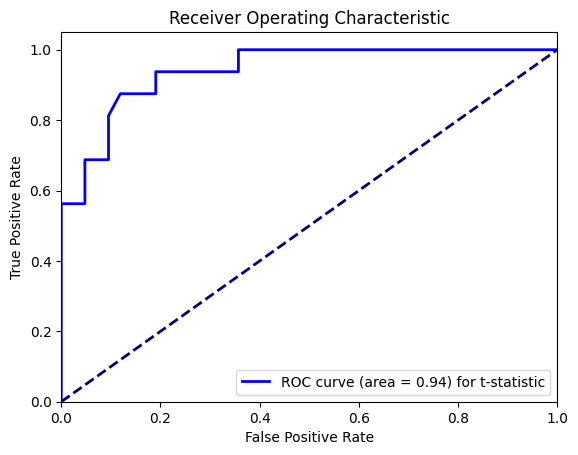

In [26]:
plt.figure()
plt.plot(fpr_t, tpr_t, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_t:.2f}) for t-statistic')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Здесь диагональная линия показывает, как бы выглядела ROC-кривая для классификатора, который просто случайным образом предсказывает классы. Наша ROC-кривая лежит выше этой линии, это означает, что ваш классификатор работает лучше, чем случайное угадывание.

Рассчитаем для критерия хи-квадрат Пирсона

In [27]:
y_score_chi2 = new_tab1['chi2'].values

In [28]:
y_score_chi2

array([7.53052743e+03, 4.96516566e+03, 2.62478681e+03, 2.02311567e+03,
       1.46422444e+03, 7.32103928e+02, 7.32103928e+02, 6.88683665e+02,
       5.64526137e+02, 4.95890391e+02, 4.86739604e+02, 3.66049890e+02,
       3.66049890e+02, 1.24635125e+02, 1.20688299e+02, 1.19736034e+02,
       7.69216853e+01, 7.16203338e+01, 7.16203338e+01, 4.22338941e+01,
       4.08482946e+01, 3.89156124e+01, 3.72593598e+01, 2.94949920e+01,
       2.87001486e+01, 2.61336474e+01, 2.61096369e+01, 1.95364413e+01,
       1.81521644e+01, 1.63624189e+01, 1.36186156e+01, 1.22231556e+01,
       1.17015884e+01, 9.95357070e+00, 7.59076625e+00, 6.67294756e+00,
       6.48113955e+00, 5.21602565e+00, 5.21602565e+00, 4.60876873e+00,
       4.50016299e+00, 4.39533110e+00, 3.23709055e+00, 3.15088270e+00,
       2.87578603e+00, 2.80228717e+00, 1.07453250e+00, 8.72461107e-01,
       7.56284506e-01, 6.21391498e-01, 5.53234013e-01, 5.22971751e-01,
       3.94733018e-01, 1.65255895e-01, 1.62947068e-01, 9.93927978e-02,
      

Заполним истинные значения, соотвествующие критерию хи-квадрат Пирсона в нашей таблице

In [29]:
y_true_chi2 = np.array([1, 1, 1, 1, 
                        1, 1, 0, 1, 
                        1, 1, 0, 0, 
                        0, 1, 0, 1, 
                        0, 0, 0, 1,
                        0, 0, 0, 1, 
                        0, 0, 0, 0, 
                        1, 0, 0, 1, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 1,
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0])

In [30]:
y_score_chi2.shape

(58,)

In [32]:
y_true_chi2.shape

(58,)

In [33]:
fpr_chi2, tpr_chi2, _ = roc_curve(y_true_chi2, y_score_chi2)
roc_auc_chi2 = auc(fpr_chi2, tpr_chi2)

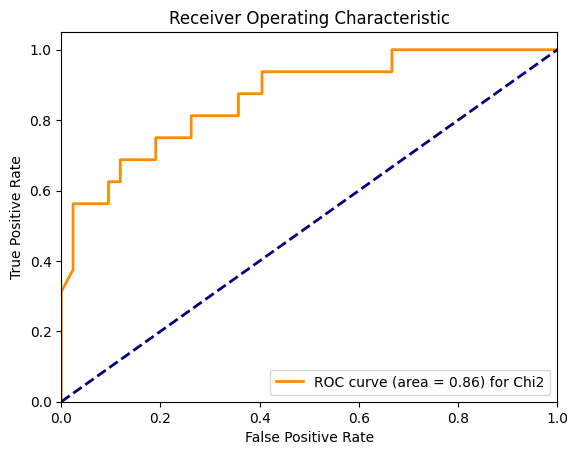

In [34]:
plt.figure()
plt.plot(fpr_chi2, tpr_chi2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_chi2:.2f}) for Chi2')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Чем дальше ваша ROC-кривая от диагональной линии, тем лучше качество классификации. Идеальный классификатор будет иметь ROC-кривую, которая стремится к левому верхнему углу графика (TPR = 1, FPR = 0).

6) Сравнить критерии по качеству классификации на основе показателя AUC (площади под ROC-кривой). Сделать выводы

AUC — это площадь под ROC-кривой. Она является важной метрикой, которая позволяет оценить качество классификации:

AUC = 1: Идеальная классификация.

AUC = 0.5: Классификатор работает как случайное угадывание.

AUC < 0.5: Классификатор работает хуже, чем случайное угадывание.

Исходя из полученных данных, мы можем сделать следующие выводы:

Значение AUC для критерия Стьюдента близко к 1, что указывает на очень хорошее качество классификации. Классификатор, использующий критерий Стьюдента, работает почти идеально. Классификатор с таким высоким AUC хорошо различает коллокации и не коллокации.

Значение AUC 0.86 также указывает на хорошее качество классификации, хотя и не такое высокое, как в случае с критерием Стьюдента. Классификатор, использующий критерий хи-квадрат, также хорошо различает коллокации и не коллокации, но не так эффективно, как в случае с критерием Стьюдента.